## Prediction of Alcohol and Flavanoids content  in wine 
The wine dataset - is standard wine dataset used in many tutorials for wine classification. However, in this notebook a new analysis of this dataset is presented, that is not targeting classification, but prediction of alcohol and flavanoids content in wine based on all other attributes.

In [5]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sbr
from matplotlib import pyplot as plt
import timeit


#import sklearn library:
from sklearn import tree
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D as Axes3D
from sklearn.decomposition import PCA
from sklearn import cross_validation
from sklearn.ensemble import AdaBoostClassifier
from sklearn import grid_search
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sfa


In [2]:
# Read dataset, add column names 
data = pd.read_csv("wine.data.txt",names=["Class","Alcohol","Malic Alic","Ash","Alcanility of Ash","Magnesium",
                    "Total phenols","Flavanoids","Nonflavanoid phenols","Proanthocyanins","Color intensity","Hue","OD280_OD315_diluted wines",
                    "Proline"])

## Explore dataset:

In [3]:
# First glance on data:
data.head()

,Class,Alcohol,Malic Alic,Ash,Alcanility of Ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280_OD315_diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


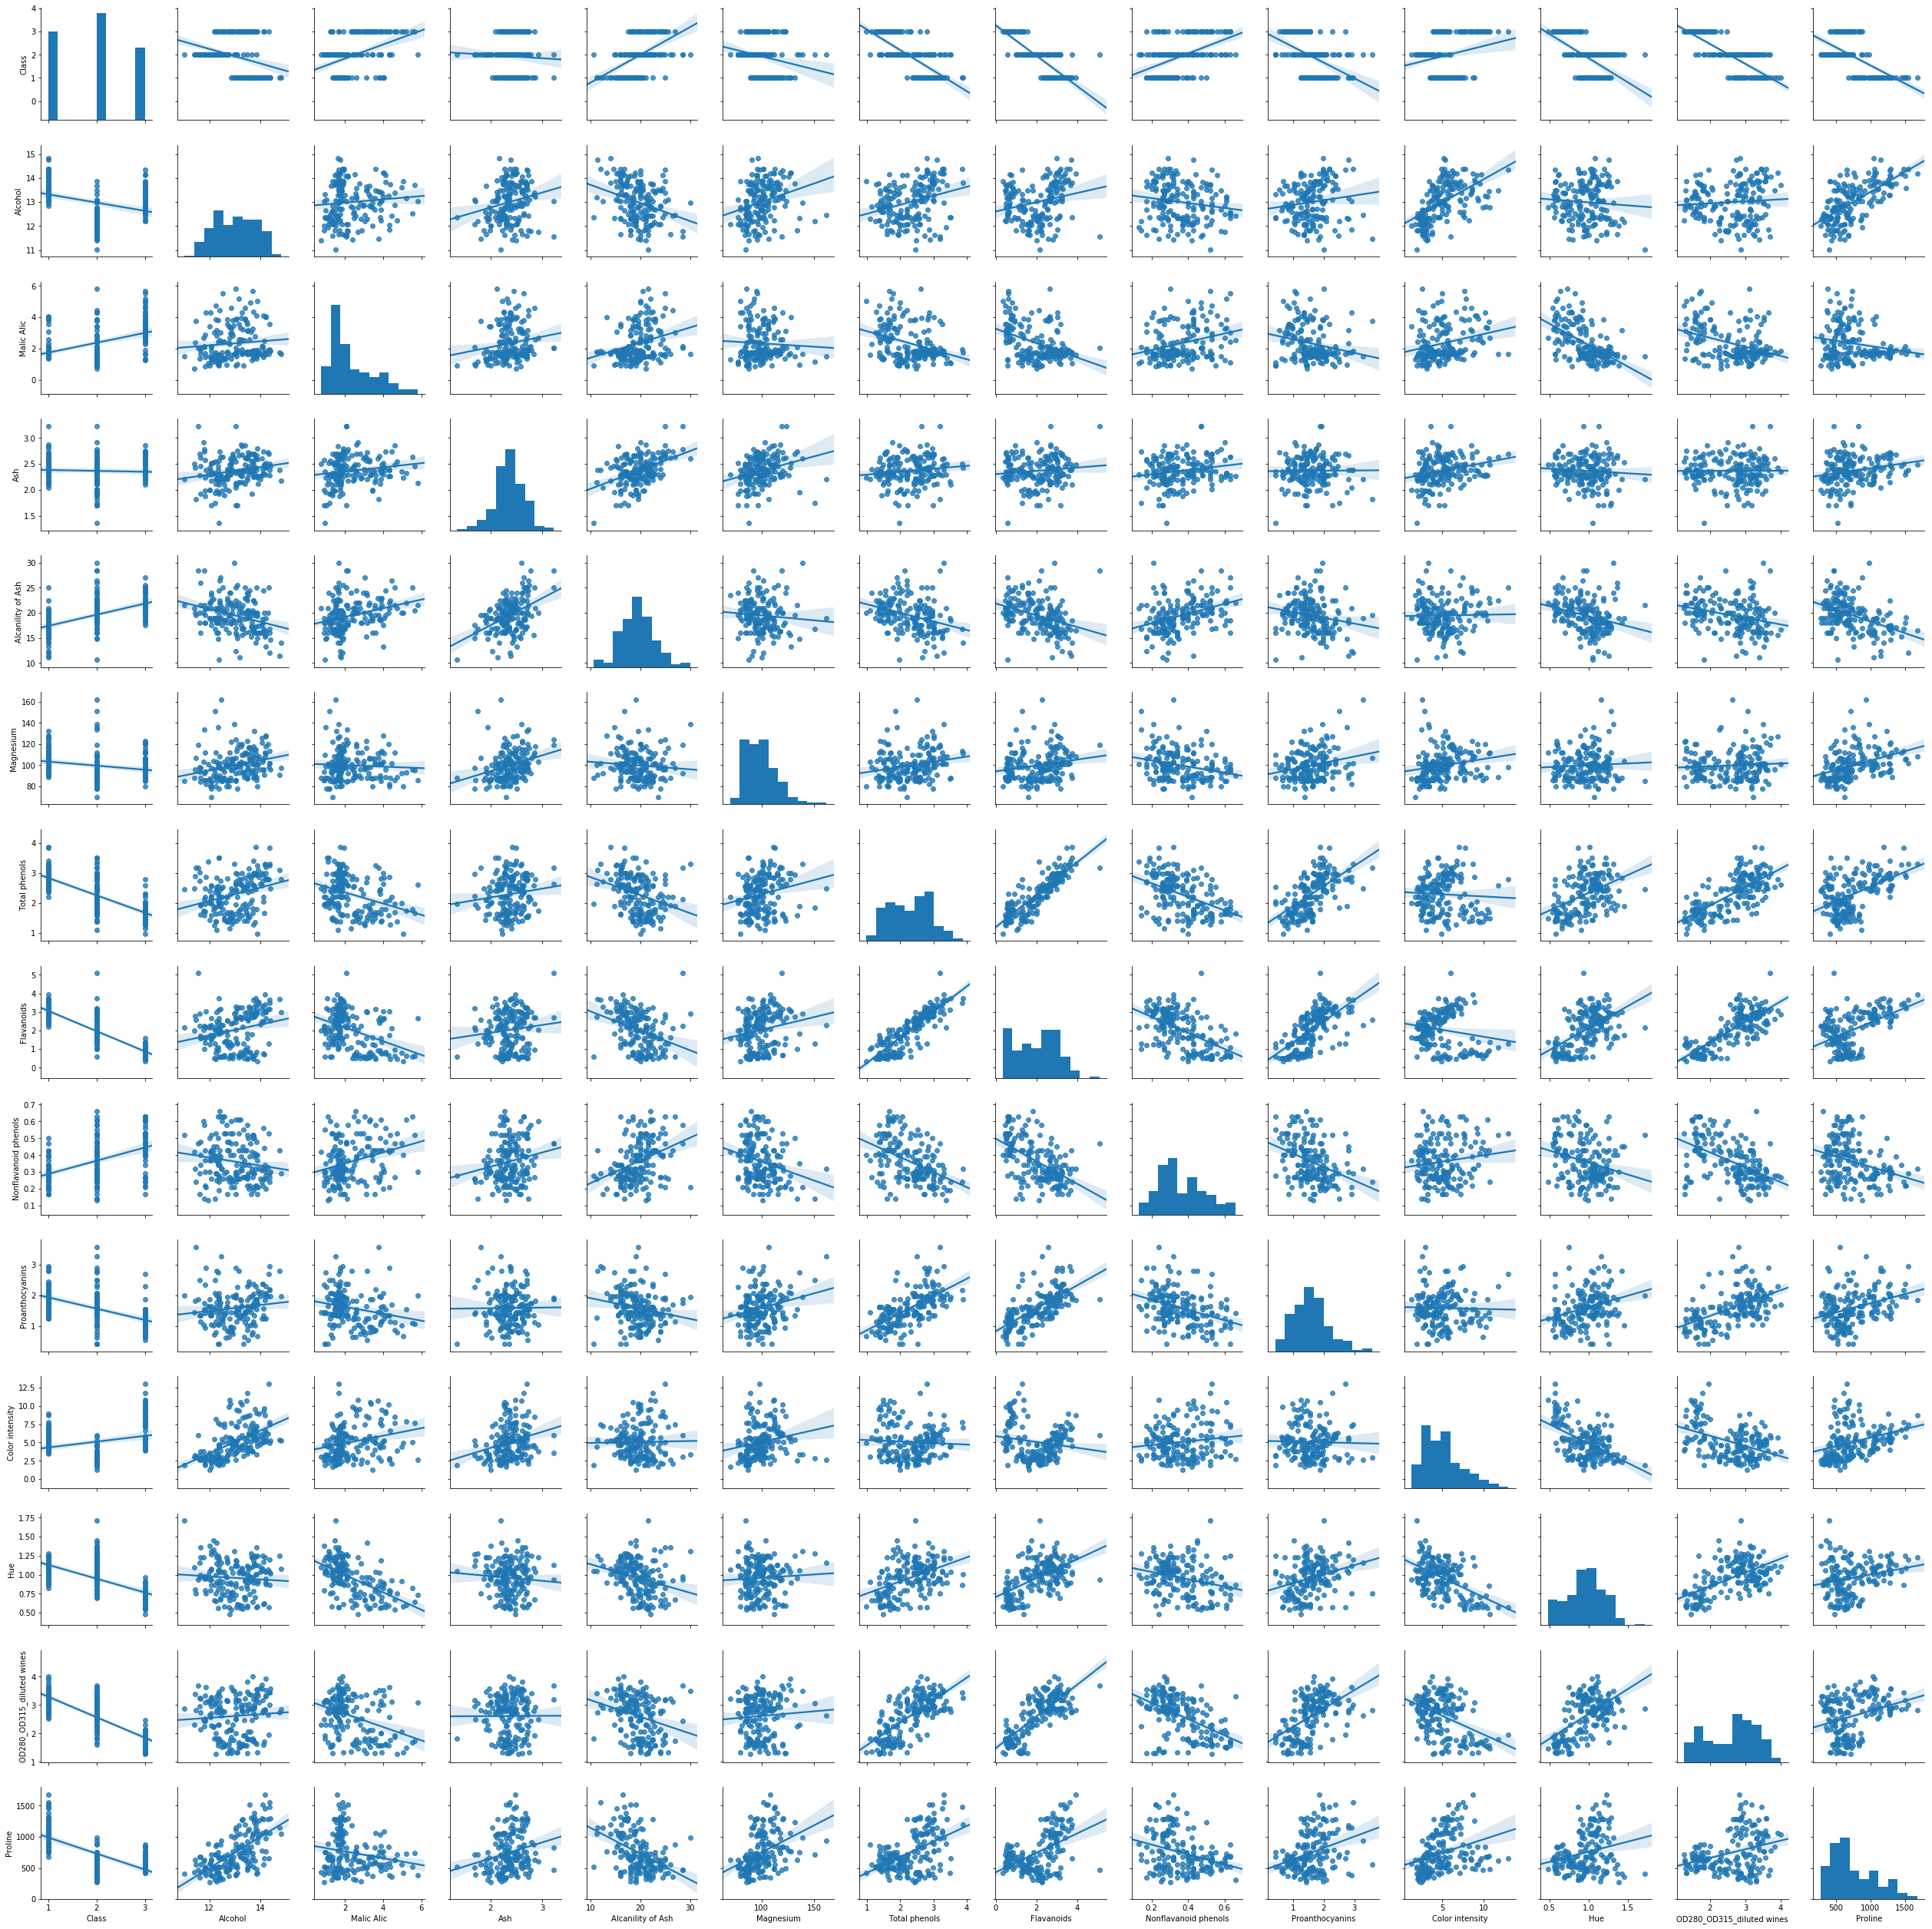

In [4]:
#check all attributes for pairwise dependensies:
sbr.pairplot(data, kind='reg')

From pairplot is can be seen that most promising wine attributes to build successful linear model are Flavanoids and Total Phenols, as they have clear linear dependency with some other attributes.  
However, from practical point of view it is more interesting to see if alcohol content can be predicted by other attributes.  From the first view alchol content has some linear dependency, but not so obvious as flavanoids content.  As further steps, linear model on both Flavanoids and Alcohol content prediction is built and performance of this model for both attributes is compared.    



1. Separate attributes of data set in x1 avs alcohol content in y1, and x2 vs flavanoids content in y2. isualize pairwise comparisson.


In [6]:
#separate attribute alcohol from other attributes and create x1 and y1:
y1 = data["Alcohol"].values.reshape(data.shape[0],1)
x1 = data.loc[:, data.columns != 'Alcohol']

In [7]:
#separate attribute alcohol from other attributes and create x2 and y2:
y2 = data["Flavanoids"].values.reshape(data.shape[0],1)
x2 = data.loc[:, data.columns != 'Flavanoids']

2. Separate pairplots for both variables to visualize dependencies better:

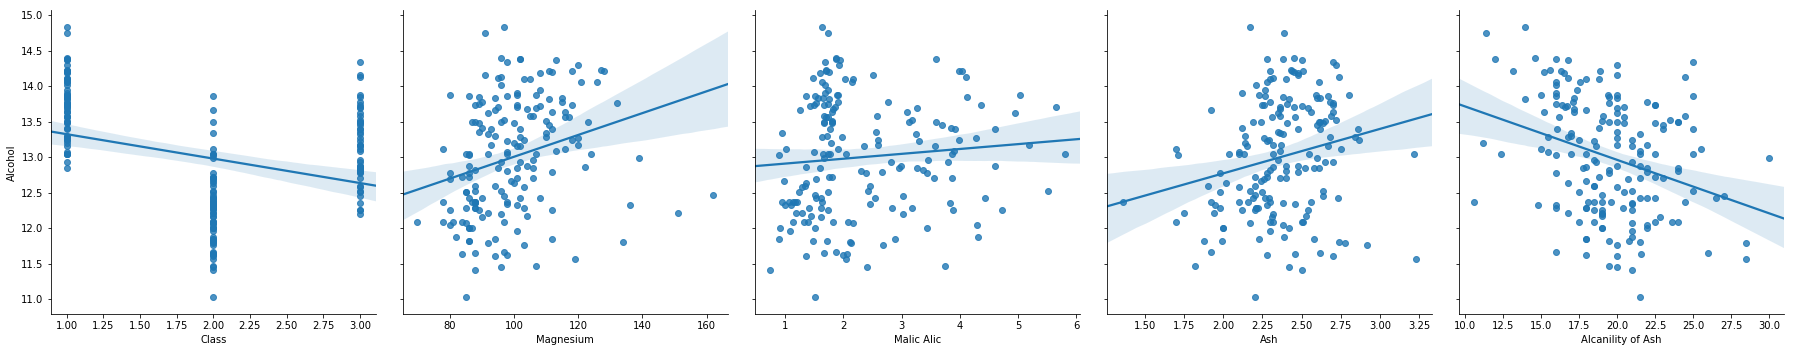

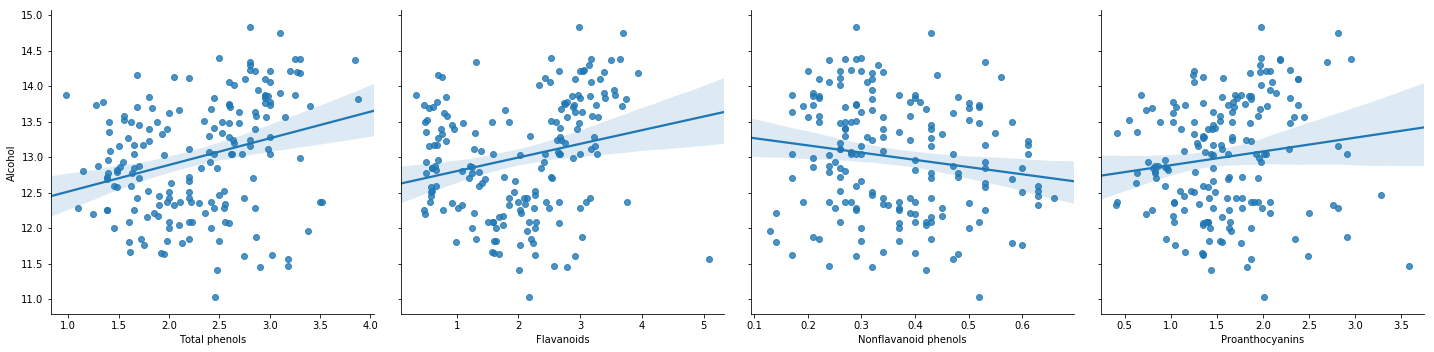

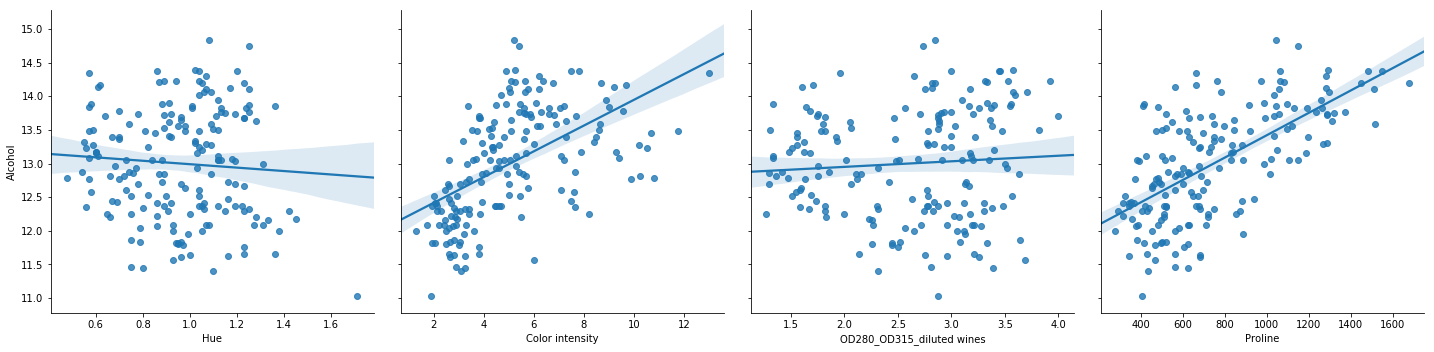

In [8]:
#visualize data pairwise ontent and fit regression line for alcohol:

sbr.pairplot(data, x_vars=["Class","Magnesium","Malic Alic","Ash", "Alcanility of Ash"], 
                           y_vars='Alcohol', size = 5, kind='reg')
                           
sbr.pairplot(data, x_vars=["Total phenols","Flavanoids", "Nonflavanoid phenols","Proanthocyanins"],\
                           y_vars='Alcohol', size = 5, kind='reg')
                
sbr.pairplot(data, x_vars=["Hue","Color intensity", "OD280_OD315_diluted wines", "Proline"],\
                           y_vars='Alcohol', size = 5, kind='reg')

From this graph can be concluded that it is not so easy to build linear regression model to predict alcohol content, and even though some variation can be explained, the model should perform very well.

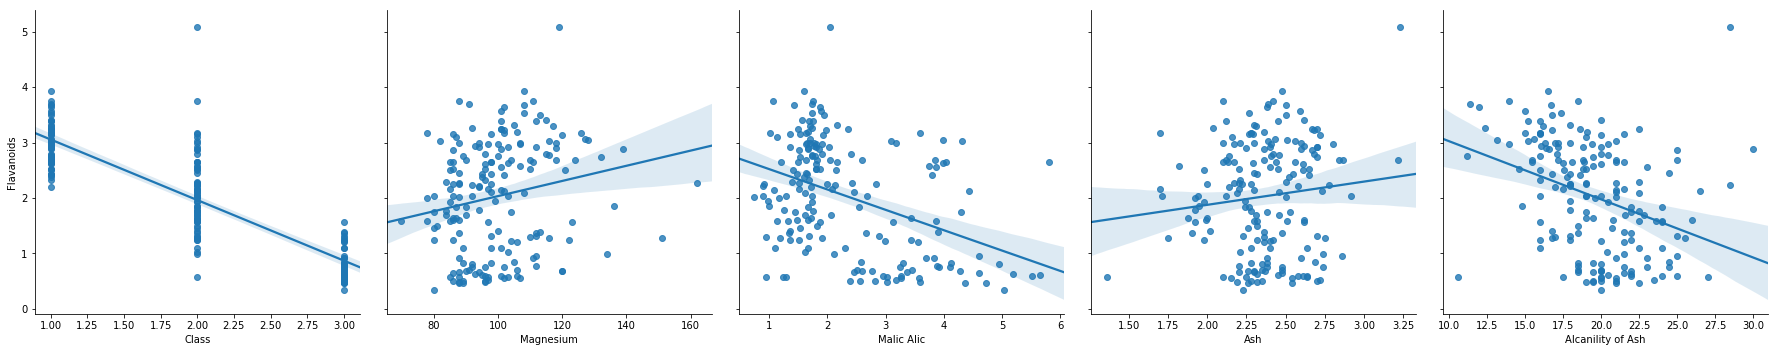

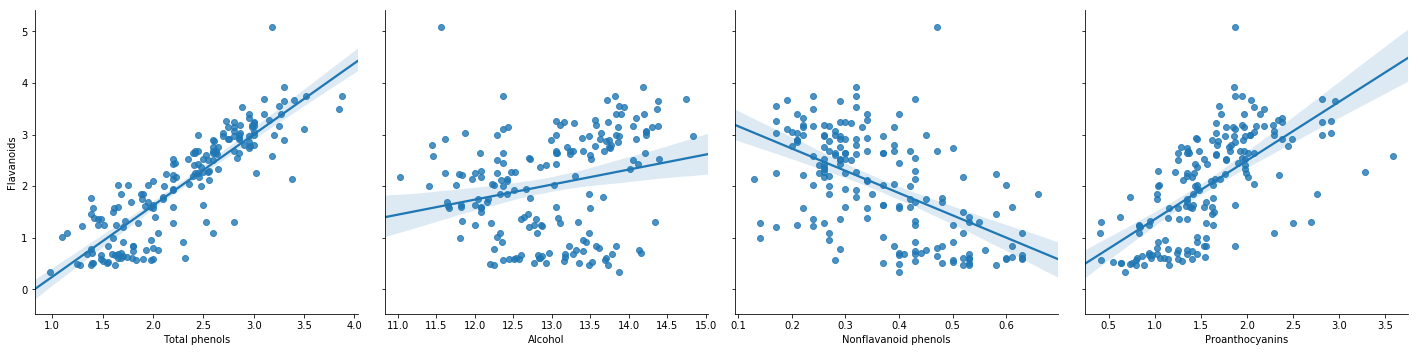

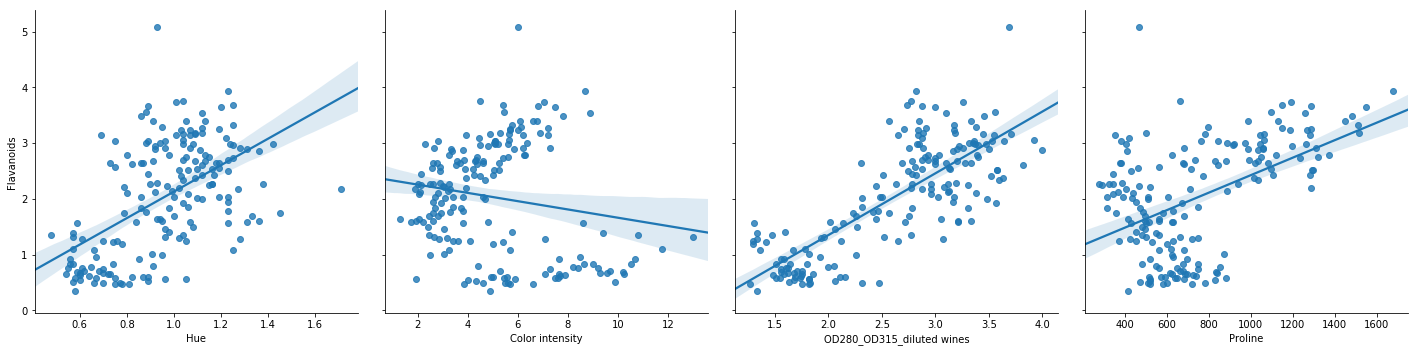

In [9]:
#visualize data pairwise ontent and fit regression line for Flavanoids content:

sbr.pairplot(data, x_vars=["Class","Magnesium","Malic Alic","Ash", "Alcanility of Ash"], 
                           y_vars='Flavanoids', size = 5, kind='reg')
                           
sbr.pairplot(data, x_vars=["Total phenols","Alcohol", "Nonflavanoid phenols","Proanthocyanins"],\
                           y_vars='Flavanoids', size = 5, kind='reg')
                
sbr.pairplot(data, x_vars=["Hue","Color intensity", "OD280_OD315_diluted wines", "Proline"],\
                           y_vars='Flavanoids', size = 5, kind='reg')

From this graph can be concluded that it worth to build linear regression model to predict flavanoids content. Moreover, polynomial regression should fit even better. 

## Step-by-step Linear Regression Model (gradient descent):

(For education purposes I will build step-by-step Linear Regression Model and compare it to SkLearn model)

### Build linear regression from scratch and compare it to sklearn LinearRegression function

In [48]:
## divide dataset into training and test set:

def divide_set (x, y):
    
    # add column with all ones to x - to compensate for W0 and convert x to np.array
    x["w0"] = np.ones([x.shape[0],1]) 
    #normalize datapoints
    x_norm = (x - x.mean(axis = 0))/x.std(axis = 0)
    # add column with all ones to x - to compensate for W0 and convert x to np.array also, convert back class to category
    x_norm["w0"] = np.ones([x.shape[0],1])
    # create array with count from 1 to len(y) and shuffle it:
    idx = np.random.permutation(np.array(range(len(y))))
    n = int(0.8* len(y))
    x_train = x_norm.values[idx[:n]]
    y_train = y[idx[:n]]
    x_test = x_norm.values[idx[n:]]
    y_test = y[idx[n:]]
    return x_train, x_test, y_train, y_test

In [49]:
#initialize weights ():
def initialize (x_train):
    
    w= np.zeros([x_train.shape[1],1]) 
    return w

In [50]:
#forward propagation function:

def forward_prop(x_train, w):
    y_predict = np.dot(x_train,w)
    
    return y_predict

In [51]:
#cost function:

def cost_function(y_train, y_predict, reg, w):
    
    cost = (np.sum(np.square(y_predict - y_train)) + reg*np.sum(np.square(w)))/(2*len(y_train))
    
    return cost

In [52]:
# backward propagation function:

def back_prop(w, y_train, y_predict, learning_rate, x_train, reg):
    
    w -= (learning_rate/len(y_train))*(np.dot(x_train.T, (y_predict-y_train))+reg*np.sum(w))
    
    return w
    

### Apply step-by-step Linear Model to predict alcohol content:

Learning rate: 0.01 Regression Coefficient: 0


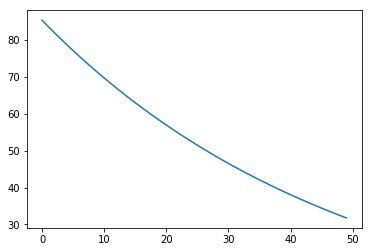

R^2 score: -115.83098857251409
Root Mean Squared Error for test data: 7.846607283260725
Root Mean Squared Error for train data: 7.8926993930677005
--------------------------------------------------
Learning rate: 0.05 Regression Coefficient: 0


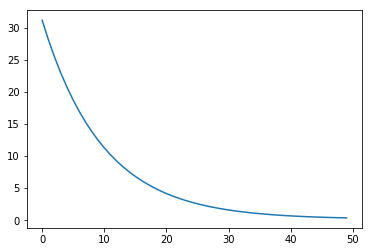

R^2 score: -0.09146341520495915
Root Mean Squared Error for test data: 0.7584159935391325
Root Mean Squared Error for train data: 0.8145700116593663
--------------------------------------------------
Learning rate: 0.1 Regression Coefficient: 0


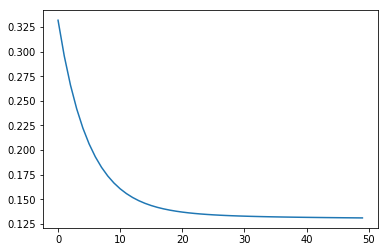

R^2 score: 0.5315683216108646
Root Mean Squared Error for test data: 0.4968508302651639
Root Mean Squared Error for train data: 0.5121169920676863
--------------------------------------------------
Learning rate: 0.3 Regression Coefficient: 0


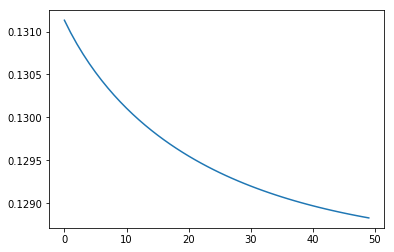

R^2 score: 0.5175478781296325
Root Mean Squared Error for test data: 0.5042315331582724
Root Mean Squared Error for train data: 0.5075744360644304
--------------------------------------------------


In [53]:
# train model for alcohol content:

iterations = 50
learning_rates = [0.01, 0.05,  0.1, 0.3]
reg = 0

# start time counting:
start1 = timeit.default_timer()

x_train1, x_test1, y_train1, y_test1 = divide_set(x1, y1)

start1 = timeit.default_timer()
w1 = initialize(x_train1)

for learning_rate in learning_rates:
        print("Learning rate:",learning_rate, "Regression Coefficient:", reg)
        costs1 = []
        for i in range(iterations):
            #convert x from dataframe to array   
            y_predict1 = forward_prop(x_train1,w1)
            cost1= cost_function(y_train1, y_predict1, reg, w1)
            costs1.append(cost1)
            w1 = back_prop(w1, y_train1, y_predict1, learning_rate, x_train1, reg)
       
        # plot cost function:      
        plt.plot(np.arange(iterations), costs1)
        plt.show()

        # check accuracy for Alcohol content: 

        y_predict1 = forward_prop(x_test1,w1)
        y_predict_train1 = forward_prop(x_train1,w1)

        error_mean_train1 = np.sqrt(np.mean(np.square(y_predict_train1 - y_train1)))
        error_mean1 = np.sqrt(np.mean(np.square(y_predict1 - y_test1)))

        r_value1 = 1 - np.sum(np.square(y_predict1 - y_test1))/np.sum(np.square(y_test1 - np.mean(y_test1)))

        print("R^2 score:", r_value1 )
        print("Root Mean Squared Error for test data:", error_mean1)
        print("Root Mean Squared Error for train data:", error_mean_train1)
        print("--------------------------------------------------")
        
        
        
        

According to data above, the best parameters are learning_rate 0.1

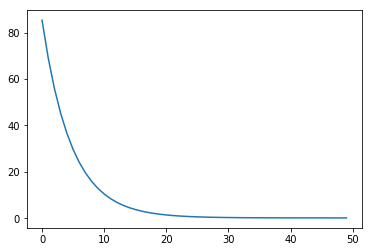

In [54]:
# train model for Alcohol content:

iterations = 50
learning_rate = 0.1
reg = 0

w1 = initialize(x_train1)
costs1 = []
start1 = timeit.default_timer()
for i in range(iterations):
        #convert x from dataframe to array
    y_predict1 = forward_prop(x_train1,w1)
    cost1= cost_function(y_train1, y_predict1, reg, w1)
    costs1.append(cost1)
    w1 = back_prop(w1, y_train1, y_predict1, learning_rate, x_train1, reg)
stop1 = timeit.default_timer()
        # plot cost function:      
plt.plot(np.arange(iterations), costs1)

In [55]:
# check accuracy for Alcohol content: 

y_predict1 = forward_prop(x_test1,w1)
y_predict_train1 = forward_prop(x_train1,w1)

error_mean_train1 = np.sqrt(np.mean(np.square(y_predict_train1 - y_train1)))
error_mean1 = np.sqrt(np.mean(np.square(y_predict1 - y_test1)))
error_std1 = np.sqrt(np.std(np.square(y_predict1 - y_test1)))
error_std_train1 = np.sqrt(np.std(np.square(y_predict_train1 - y_train1)))

r_value1 = 1 - np.sum(np.square(y_predict1 - y_test1))/np.sum(np.square(y_test1 - np.mean(y_test1)))

print("R^2 score:", r_value1 )
print("Root Mean Squared Error for test data:", error_mean1, "and standard deviation:",error_std1)
print("Root Mean Squared Error for train data:", error_mean_train1, "and standard deviation:",error_std_train1)
print("Intercept:",w1[-1], "Coefficients:", w1[:-1].T)

R^2 score: 0.5386133718016302
Root Mean Squared Error for test data: 0.49310044351857485 and standard deviation: 0.49736598934619325
Root Mean Squared Error for train data: 0.5225853787034472 and standard deviation: 0.6266285625131616
Intercept: [12.94911672] Coefficients: [[-0.16573985  0.2321057   0.05995163 -0.12783638 -0.02180218  0.07161812
  -0.09121171 -0.06842854 -0.10690431  0.42149757  0.12048978  0.06901451
   0.28250067]]


### Apply step-by-step Linear Model to predict flavanoids content:

Learning rate: 0.01 Regression Coefficient: 0


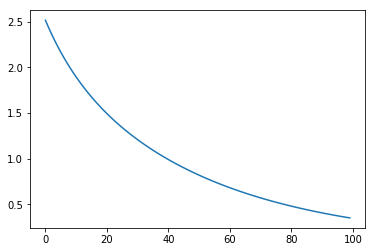

R^2 score: 0.00839807622919353
Root Mean Squared Error for test data: 0.9699761001293128
Root Mean Squared Error for train data: 0.830604834578943
Learning rate: 0.05 Regression Coefficient: 0


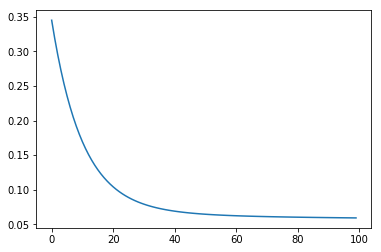

R^2 score: 0.8938457570899508
Root Mean Squared Error for test data: 0.3173664630873514
Root Mean Squared Error for train data: 0.3439159417255387
Learning rate: 0.1 Regression Coefficient: 0


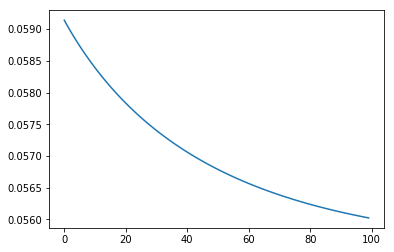

R^2 score: 0.9007803665768379
Root Mean Squared Error for test data: 0.30682529629953137
Root Mean Squared Error for train data: 0.33470607723076107
Learning rate: 0.03 Regression Coefficient: 0


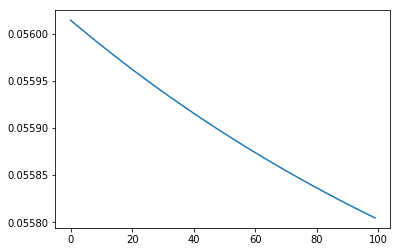

R^2 score: 0.9009292998303502
Root Mean Squared Error for test data: 0.30659493034735913
Root Mean Squared Error for train data: 0.3340751143377377


In [56]:
# train model for Flavanoids content for set of learning rates:

iterations = 100
learning_rates = [0.01, 0.05, 0.1, 0.03]
reg = 0

x_train2, x_test2, y_train2, y_test2 = divide_set(x2, y2)
w2 = initialize(x_train2)


for learning_rate in learning_rates:
    print("Learning rate:",learning_rate, "Regression Coefficient:", reg)
    costs2 = []
    for i in range(iterations):
            #convert x from dataframe to array
        y_predict2 = forward_prop(x_train2,w2)
        cost2= cost_function(y_train2, y_predict2, reg, w2)
        costs2.append(cost2)
        w2 = back_prop(w2, y_train2, y_predict2, learning_rate, x_train2, reg)

            # plot cost function:      
    plt.plot(np.arange(iterations), costs2)
    plt.show()
    
    y_predict2 = forward_prop(x_test2,w2)
    y_predict_train2 = forward_prop(x_train2,w2)

    error_mean2 = np.sqrt(np.mean(np.square(y_predict2 - y_test2)))
    error_mean_train2 = np.sqrt(np.mean(np.square(y_predict_train2 - y_train2)))
    r_value2 = 1 - np.sum(np.square(y_predict2 - y_test2))/np.sum(np.square(y_test2 - np.mean(y_test2)))
    
    print("R^2 score:", r_value2 )
    print("Root Mean Squared Error for test data:", error_mean2)
    print("Root Mean Squared Error for train data:", error_mean_train2)
    

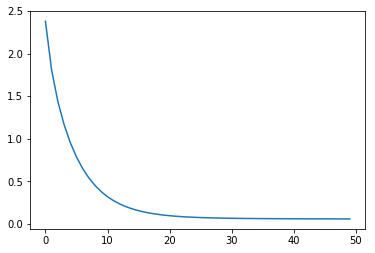

In [57]:
# train model for Flavanoids content:

iterations = 50
learning_rate = 0.1
reg = 0

x_train2, x_test2, y_train2, y_test2 = divide_set(x2, y2)
w2 = initialize(x_train2)
costs2 = []

for i in range(iterations):
        #convert x from dataframe to array
    y_predict2 = forward_prop(x_train2,w2)
    cost2= cost_function(y_train2, y_predict2, reg, w2)
    costs2.append(cost2)
    w2 = back_prop(w2, y_train2, y_predict2, learning_rate, x_train2, reg)

        # plot cost function:      
plt.plot(np.arange(iterations), costs2)

In [58]:
# check accuracy for Flavanoids content: 

y_predict2 = forward_prop(x_test2,w2)
y_predict_train2 = forward_prop(x_train2,w2)

error_mean2 = np.sqrt(np.mean(np.square(y_predict2 - y_test2)))
error_mean_train2 = np.sqrt(np.mean(np.square(y_predict_train2 - y_train2)))
error_std2 = np.sqrt(np.std(np.square(y_predict2 - y_test2)))
error_std_train2 = np.sqrt(np.std(np.square(y_predict_train2 - y_train2)))

r_value2 = 1 - np.sum(np.square(y_predict2 - y_test2))/np.sum(np.square(y_test2 - np.mean(y_test2)))

print("R^2 score:", r_value2 )
print("Root Mean Squared Error for test data:", error_mean2,  "and standard deviation:",error_std2 )
print("Root Mean Squared Error for train data:", error_mean_train2, "and standard deviation:",error_std_train2)
print("Intercept:",w2[-1], "Coefficients:", w2[:-1].T)

R^2 score: 0.8501977006503127
Root Mean Squared Error for test data: 0.3579554956100563 and standard deviation: 0.4739271132783959
Root Mean Squared Error for train data: 0.34238478058248467 and standard deviation: 0.6015901454291271
Intercept: [1.98817023] Coefficients: [[-0.31334963 -0.02868451 -0.01302957  0.13196732 -0.01622763 -0.04011488
   0.31306291 -0.09250581  0.19307403  0.04578679  0.08135572  0.14667473
  -0.03392801]]


## Modeling with sklearn:

### Linear Regression for alcohol content prediction:

In [59]:
start2 = timeit.default_timer()

linear_reg1 = LinearRegression().fit(x_train1, y_train1)

stop2 = timeit.default_timer()
print("time to train model", stop2-start2) 

print("r^2 score:",linear_reg1.score(x_test1, y_test1))
error_mean_sk1 = np.sqrt(np.mean(np.square(linear_reg1.predict(x_test1) - y_test1)))
error_std_sk1 = np.sqrt(np.std(np.square(linear_reg1.predict(x_test1) - y_test1))) 
print("Root Mean Squared Error:", error_mean_sk1, "with standard deviation:", error_std_sk1)


time to train model 0.001223241095431149
r^2 score: 0.5047460739349272
Root Mean Squared Error: 0.510877592745506 with standard deviation: 0.5392552172875079


### Linear Regression for flavanoids content prediction:

In [60]:
linear_reg2 = LinearRegression().fit(x_train2, y_train2)
print("r^2 score:",linear_reg2.score(x_test2, y_test2))

error_mean_sk2 = np.sqrt(np.mean(np.square(linear_reg2.predict(x_test2) - y_test2)))
error_std_sk2 = np.sqrt(np.std(np.square(linear_reg2.predict(x_test2) - y_test2))) 
print("Root Mean Squared Error:", error_mean_sk2, "with standard deviation:", error_std_sk2)
print("Intercept:",linear_reg2.intercept_, "Coefficients:",linear_reg2.coef_)

r^2 score: 0.8517803038140531
Root Mean Squared Error: 0.3560596446268656 with standard deviation: 0.4660507781394112
Intercept: [2.00265244] Coefficients: [[-0.56850655 -0.08027317  0.01730998  0.08776491  0.03696947 -0.03572081
   0.33262454 -0.09095566  0.15228615  0.15471205  0.08140545  0.06160278
  -0.14385688  0.        ]]


## Model comparisson:

### 1. Comparison of linear regression model for Flavanoids and Alchohol: 




In [61]:
print("Linear Regression to predict alcohol content")
print("r^2 score:",linear_reg1.score(x_test1, y_test1))
print("Root Mean Squared Error:", error_mean_sk1, "with standard deviation:", error_std_sk1)
print("Alcohol content data mean:",np.mean(data["Alcohol"])," and std:",np.std(data["Alcohol"] ))
print("----------------------------------------------------------------------")

print("Linear Regression to predict flavanoids content")
print("r^2 score:",linear_reg2.score(x_test2, y_test2))
print("Root Mean Squared Error:", error_mean_sk2, "with standard deviation:", error_std_sk2)
print("Flavanoids content data mean:",np.mean(data["Flavanoids"])," and std:",np.std(data["Flavanoids"] ))

Linear Regression to predict alcohol content
r^2 score: 0.5047460739349272
Root Mean Squared Error: 0.510877592745506 with standard deviation: 0.5392552172875079
Alcohol content data mean: 13.000617977528083  and std: 0.809542914528517
----------------------------------------------------------------------
Linear Regression to predict flavanoids content
r^2 score: 0.8517803038140531
Root Mean Squared Error: 0.3560596446268656 with standard deviation: 0.4660507781394112
Flavanoids content data mean: 2.0292696629213474  and std: 0.9960489503792328


It can be seen that for the alcohol model, root mean square error of prediction is approximatelly 0.6 of standard deviation of alcohol content in dataset and linear regression explains around 50-60% of variation.  
For flavanoids model root mean square error of prediction is approximatelly 0.3 of standard deviation of flavanoids content in dataset and linear regression performs much better - around 80-90% of variation in data is explained

### 2. Comparison of performance for step-by-step and skLearn linear regression:

In [62]:
print("Step-by-step linear Regression to predict alcohol content")
print("R^2 score:", r_value1 )
print("Root Mean Squared Error:", error_mean1, "with standard deviation:", error_std1)
print("time to train model", stop1-start1) 
print("----------------------------------------------------------------------")
print("SkLearn linear Regression to predict alcohol content")
print("r^2 score:",linear_reg1.score(x_test1, y_test1))
print("Root Mean Squared Error:", error_mean_sk1, "with standard deviation:", error_std_sk1)
print("time to train model", stop2-start2) 

Step-by-step linear Regression to predict alcohol content
R^2 score: 0.5386133718016302
Root Mean Squared Error: 0.49310044351857485 with standard deviation: 0.49736598934619325
time to train model 0.006011393037624657
----------------------------------------------------------------------
SkLearn linear Regression to predict alcohol content
r^2 score: 0.5047460739349272
Root Mean Squared Error: 0.510877592745506 with standard deviation: 0.5392552172875079
time to train model 0.001223241095431149


Accuracy:  
It can be seen that models perform very similar to each other and it is impossible to say which one is better. To prove this boxplots are made and t-test performed below  
Time:  
Time performance from SkLearn seems to be better. Possibly finding better learning rate and decreasing amount of iterations for step-by-step model could lead to similar performance. But it requres time to tune those parameters. 

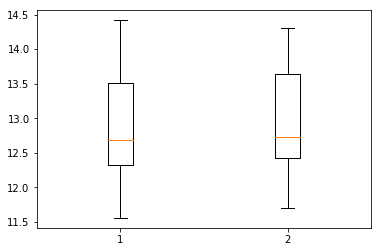

In [63]:
#box-plot for Alcohol content for both models:
plt.boxplot(np.concatenate((y_predict1, linear_reg1.predict(x_test1)), axis =1))
plt.show()

t-test:

Independent t-test: even though datapoins are the same and it can seem that paired t-test should be performed, in this specific case we are more interested to look at total prediction error, rather than checking how different is error for each separate point.
alpha - 0.05
h0: means equal
h1: means are not equal 

In [64]:
t, p = stats.ttest_ind(y_predict1, linear_reg1.predict(x_test1))
print("t = " + str(t))
print("p-value = " + str(p))

t = [-0.53106783]
p-value = [0.59705286]


Acconding to t-test results (p-value>0.05) and boxplots, assumption that means of prediction error sklearn and step-by-step model is confirmed with 95% confidence 